# Template Notebook
Notebook template with the stucture of the notebook and some default codes

## Root folder and read env variables

In [1]:
import os
# fix root path to save outputs
actual_path = os.path.abspath(os.getcwd())
list_root_path = actual_path.split('\\')[:-1]
root_path = '\\'.join(list_root_path)
os.chdir(root_path)
print('root path: ', root_path)

root path:  D:\github-mi-repo\Optimization-Industrial-Process


In [2]:
import os
from dotenv import load_dotenv, find_dotenv # package used in jupyter notebook to read the variables in file .env

""" get env variable from .env """
load_dotenv(find_dotenv())

""" Read env variables and save it as python variable """
PROJECT_GCP = os.environ.get("PROJECT_GCP", "")

## I) PACKAGES

In [3]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import gcsfs
import pickle

# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import iqr

# plots
import matplotlib.pyplot as plt

# explanaible AI
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# #shap - shapash
# import shap
# from shapash import SmartExplainer

In [4]:
### desarrollo

PROJECT_ID = PROJECT_GCP
! gcloud config set project $PROJECT_ID

ERROR: (gcloud.config.set) There was a problem refreshing your current auth tokens: HTTPSConnectionPool(host='oauth2.googleapis.com', port=443): Max retries exceeded with url: /token (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002385AA320A0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Please run:

  $ gcloud auth login

to obtain new credentials.

If you have already logged in with a different account, run:

  $ gcloud config set account ACCOUNT

to select an already authenticated account to use.


## II) LOAD ARTIFACTS MODEL

### 1. Load model name

In [5]:
# model name that indicate what process it is modelling and not what kind of machine learning model was trained
name_model = 'd0eop_microkappa'
#name_model = 'd1_brillo'
#name_model = 'p_blancura'

### 2. Load data test (X_test, y_test)

In [6]:
# X_train
path_X_train = f'artifacts/data_training/{name_model}/X_train.pkl'
X_train = pd.read_pickle(path_X_train)

# y_train
path_y_train = f'artifacts/data_training/{name_model}/y_train.pkl'
y_train = pd.read_pickle(path_y_train)

In [7]:
# X_test
path_X_test = f'artifacts/data_training/{name_model}/X_test.pkl'
X_test = pd.read_pickle(path_X_test)

# y_test
path_y_test = f'artifacts/data_training/{name_model}/y_test.pkl'
y_test = pd.read_pickle(path_y_test)

In [8]:
print('SHAPE DATA')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)

print('\n')
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

SHAPE DATA
X_train:  (114560, 10)
y_train:  (114560, 1)


X_test:  (28640, 10)
y_test:  (28640, 1)


### 3. Load model trained

In [9]:
# load model
path_model = f'artifacts/models/{name_model}/lr.pkl'
model = pd.read_pickle(path_model)
model

Pipeline(steps=[('poly_feature_2', PolynomialFeatures()),
                ('lr', LinearRegression())])

In [10]:
# define a string with the name of the kind of machine learning model was trained
model_type_string = 'Linear Regression'

In [11]:
# get a model name and type of model
name_model_and_type = name_model + '//' + model_type_string
name_model_and_type

'd0eop_microkappa//Linear Regression'

### 4. Load list features

In [12]:
path_list_features_target_to_optimization = f'config/optimization_engine/ml_models/MaestroTags-{name_model}-general.xlsx'
maestro_tags = pd.read_excel(path_list_features_target_to_optimization)
maestro_tags

,TAG,TAG_DESCRIPTION,DESCRIPCION,ETAPA,CLASIFICACION,USE_PREVIOUS_MODEL,USE_NEXT_MODEL
0,calc_prod_d0,calc_prod_d0,Producción entrada D0 (prod entrada A dezplazada),D0,NC,NaN,NaN
1,240AIC022.MEAS,ph_a,pH entrada etapa Acida,A,NC,NaN,NaN
2,240AIT063B.PNT,brillo_d0,Brillo salida etapa A (entrada D0),D0,NC,NaN,NaN
3,240AIT063A.PNT,kappa_d0,Kappa salida etapa A (entrada D0),D0,NC,NaN,NaN
4,S276PER002,concentracion_clo2_d0,Concentración ClO2,D0,NC,NaN,NaN
5,SSTRIPPING015,dqo_evaporadores,DQO Evaporadores,D0,NC,NaN,NaN
6,240FY050.RO02,especifico_dioxido_d0,Específico ClO2,D0,C,NaN,NaN
7,240FY11PB.RO01,especifico_peroxido_eop,Esp. Peróxido,EOP,C,NaN,NaN
8,240FY118B.RO01,especifico_oxigeno_eop,Esp. Oxígeno,EOP,C,NaN,NaN
9,240FY107A.RO01,especifico_soda_eop,Esp. Soda EOP,EOP,C,NaN,NaN


## III) OFFLINE EVALUATION MODEL
The offline evaluation of the model consist in evaluate how the model perform with its metrics and how the model will perform using to create a prescriptive machine learning systems. To achieve that not only the mean metrics with all data matters, also it is neccesary to see how to model perform into a delta change in the values, the model can generalize the data but not overtitting it, if there is some group of data that the model doesn't work, etc

The list of offline evaluation are:

1. Metrics

2. Plots predictions

3. Explanaible AI

4. Peturbation tests / Sensitivy Analysis

5. Metrics by segments

### 0. Get predictions

In [13]:
# predict
y_test_pred = model.predict(X_test)

# transform dataframe
y_test_pred = pd.DataFrame(y_test_pred)
y_test_pred.columns = y_test.columns
y_test_pred.index = y_test.index

y_test_pred.head()

,240AIT225A.PNT
datetime,
2022-05-02 02:25:00,2.093558
2021-03-20 04:45:00,2.297838
2021-12-16 18:20:00,2.091340
2021-12-26 00:55:00,2.284514
2021-11-22 01:50:00,2.238232


### 1. Metrics
**Group 1 R2**
- R2

**Group 2 MSE**
- MSE

**Group 3 RMSE**
- RMSE
- RMSE MEAN RATIO (rmse mean ratio: rmse / mean_y_true)
- RMSE IQR RATIO (rmse iqr ratio: rmse / iqr_y_true)

**Group 4 MAE**
- MAE
- MAE MEAN RATIO
- MAE IQR RATIO

------
Calculating metrics for:
- Model trained
- Basic Model - mean target / predict common class
- Baseline Model
- Last best Model

#### 1.1 Metric for Model trained

In [14]:
def calculate_metrics_regressors_models(y, y_pred, model_name, decimals_round = None):
    """
    Calculate a certain number of metrics to evaluate regression models. The metrics are rounded to X decimals

    Args
        y (dataframe): y true
        y_pred (dataframe): y predicted with the model. In this codes are passed y_pred instead of X
        model_name (string): name of the model. This name is used when the metrics are saved to identify the model of these metrics
        decimals_round = Number of decimals to round the values. Defult None, no round the values.

    Return
        metrics_regressors (dataframe): dataframe with the metrics of the model in this datasets. Row: name metrics. Columns: value metrics
    """

    #### R2
    r2 = r2_score(y, y_pred)
    
    #### MSE
    mse = mean_squared_error(y, y_pred, squared = True)
    
    #### RMSE
    rmse = mean_squared_error(y, y_pred, squared = False)
    
    #### RMSE_MEAN_RATIO
    # rmse mean ratio: rmse / mean_y_true
    rmse_mean_ratio = rmse / y.mean().values[0]
    rmse_mean_ratio = round(100 * (rmse_mean_ratio), 2)
    
    #### RMSE_IQR_RATIO
    # rmse iqr ratio: rmse / iqr_y_true
    rmse_iqr_ratio = rmse / iqr(y)
    rmse_iqr_ratio = round(100 * (rmse_iqr_ratio), 2)
    
    #### MAE
    mae = mean_absolute_error(y, y_pred)
    
    #### MAE_RATIO
    mae_mean_ratio = mae / y.mean().values[0]
    mae_mean_ratio = round(100 * (mae_mean_ratio), 2)
    
    #### MAE_IQR_RATIO
    mae_iqr_ratio = mae / iqr(y)
    mae_iqr_ratio = round(100 * (mae_iqr_ratio), 2)
    
    
    
    #### JOIN INTO ONE DATAFRAME
    # create dataframe
    metrics_regressors = pd.DataFrame(index = [model_name])
    
    # add metrics
    metrics_regressors['r2'] = r2
    metrics_regressors['mse'] = mse
    metrics_regressors['rmse'] = rmse
    metrics_regressors['rmse_mean_ratio(%)'] = rmse_mean_ratio
    metrics_regressors['rmse_iqr_ratio(%)'] = rmse_iqr_ratio
    metrics_regressors['mae'] = mae
    metrics_regressors['mae_mean_ratio(%)'] = mae_mean_ratio
    metrics_regressors['mae_iqr_ratio(%)'] = mae_iqr_ratio
    
    # round
    metrics_regressors = metrics_regressors.astype('float')
    if decimals_round:
        metrics_regressors = metrics_regressors.round(decimals_round)


    return metrics_regressors

In [15]:
metrics = calculate_metrics_regressors_models(y = y_test, 
                                              y_pred = y_test_pred, 
                                              model_name = name_model_and_type, 
                                              decimals_round = None
                                             )
metrics

,r2,mse,rmse,rmse_mean_ratio(%),rmse_iqr_ratio(%),mae,mae_mean_ratio(%),mae_iqr_ratio(%)
d0eop_microkappa//Linear Regression,0.646607,0.018405,0.135663,6.34,42.1,0.102126,4.77,31.69


#### 1.2 Basic Model - mean target / predict common class

In [16]:
# calculate mean y train. ADJUST BASIC MODEL
y_basic_model = y_train.mean().values[0]
y_basic_model

2.141987788678421

In [17]:
# generate vector to y_pred to evaluate. obs generate len according the y_true when the mean prediction will be compared
y_basic_model_pred = pd.DataFrame(y_basic_model * np.ones([y_test.shape[0]]))
y_basic_model_pred.index = y_test.index
y_basic_model_pred.columns = y_test.columns

In [18]:
# metrics basic model
metrics_basic_model = calculate_metrics_regressors_models(y = y_test, 
                                                          y_pred = y_basic_model_pred, 
                                                          model_name = 'd0eop_microkappa//Basic Model Pred', 
                                                          decimals_round = None
                                                         )
metrics_basic_model

,r2,mse,rmse,rmse_mean_ratio(%),rmse_iqr_ratio(%),mae,mae_mean_ratio(%),mae_iqr_ratio(%)
d0eop_microkappa//Basic Model Pred,-0.000133,0.052086,0.228224,10.67,70.82,0.185018,8.65,57.41


#### 1.3 Baseline Model

#### 1.4 Last best Model

### 2. Plot Predictions
- y_true vs y_pred
- hist_errors
- trend_errors
- features vs errors

#### 2.1 y_true vs y_pred

In [19]:
def plot_y_true_vs_y_pred(y, y_pred, title_plot):
    """
    Plot y_true vs y_pred (using matplotlib figure). y_true in X-axis, y_pred in Y-axis.

    Args:
        y (dataframe): dataframe with y-true values 
        y_pred (dataframe): dataframe with y-pred values
        title_plot (string): tittle in the plot
    
    Return
        fig (figure matplolib): figure to show, download, etc
    """
    fig, ax = plt.subplots()
    scatter_plot = ax.scatter(y, y_pred, alpha=0.3, marker='x', label='y_true vs y_pred')

    # Add bisectriz
    y_bisectriz = x_bisectriz = np.linspace(y.min()[0], y.max()[0], y.shape[0])
    ax.plot(x_bisectriz, y_bisectriz, label='Bisectriz', color='red', alpha=0.3)

    # Add names to axis
    ax.set_xlabel('Y true')
    ax.set_ylabel('Y pred')
    
    ax.set_title(title_plot)
    ax.legend()

    return fig

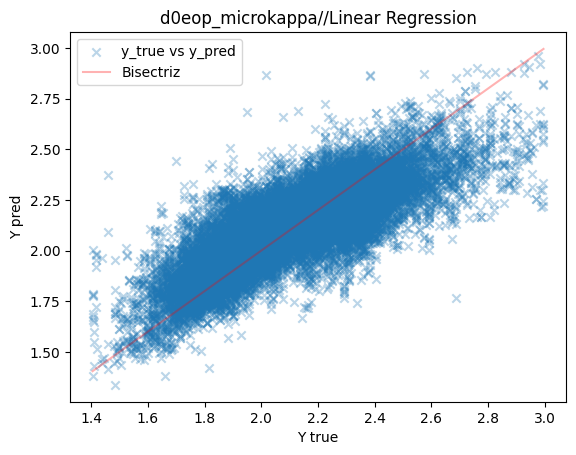

In [20]:
y_true_y_pred = plot_y_true_vs_y_pred(y = y_test, 
                                      y_pred = y_test_pred, 
                                      title_plot = name_model_and_type
                                     )

#### 2.2 hist errors

In [21]:
def hist_errors_predictions(y, y_pred, title_plot, n_bins = 10):
    """
    Plot histogram of error in prediction: errors: abs(y_true vs y_pred) (using matplotlib figure)

    Args:
        y (dataframe): dataframe with y-true values 
        y_pred (dataframe): dataframe with y-pred values
        title_plot (string): tittle in the plot
        n_bins (integer): number of bins in the histogram. Default = 10
    
    Return
        fig (figure matplolib): figure to show, download, etc
    """
    # calculate error
    errors = y - y_pred
    errors = np.abs(errors) # error in abs value
    
    # hist error
    fig = plt.figure()
    plt.hist(errors, bins = n_bins)
    plt.xlabel('Error')
    plt.ylabel('Freq')
    plt.title(f'Histogram of Errors in Predictions:  abs(y - y_pred) - {title_plot}')

    return fig

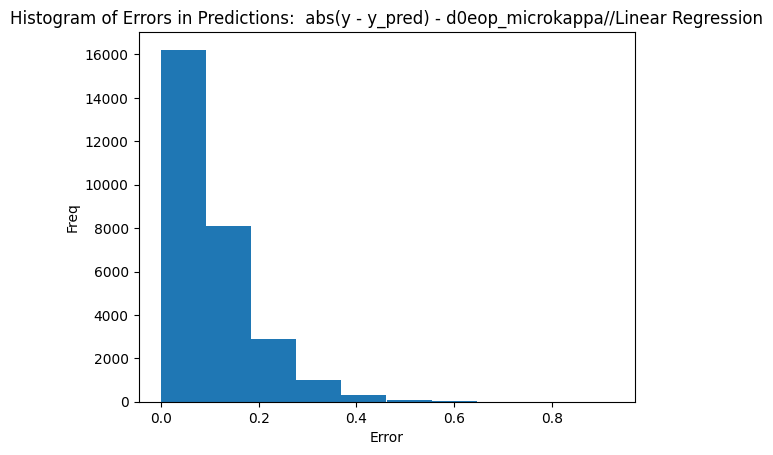

In [22]:
hist_errors = hist_errors_predictions(y = y_test, 
                                      y_pred = y_test_pred, 
                                        title_plot = name_model_and_type
                                   )

#### 2.3 Trend Errors
The split of the data was randomly instead of time split. TODO

#### 2.4 Features vs Errors
Plotear los errores para cada una de las observaciones de los datos. En el eje X se muestra los valores de una feature en concreto (pero no del resto de features que acompañan esta instancia). Son todos valores reales. La idea busca imitar a un PDP pero en lugar de utilizar los valores promedios del rsto de features se utilizan los valores reales

Intuición del gráfico
- La idea es poder terminar por ejemplo, si justo en los datos cuando las condiciones reales de operación se ven representadas por una feature X > 1000 siempre los errores son más altos

- Por ejemplo que la distribución del error en algunos segmentos sea notoriamente más alta. Se podría plantear separar el modelo hacer hacer foco en estas predicciones con los errores más altos

- Inspirado en tratar de replicar de cierta forma modelos por tramos y los modelos de boosting

In [23]:
def plot_errors_vs_one_feature(X, y, y_pred, title_plot, list_features, abs_error):
    """
    Plot errors vs features.

    Args:
        X (dataframe): dataframe with X true values - features
        y (dataframe): dataframe with y-true values 
        y_pred (dataframe): dataframe with y-pred values
        title_plot (string): tittle in the plot
        list_features (list): list of features that will plot againts the errrors. The features needs to be present in the data
        abs_error (boolean): True: Plot the absolute value of the errors abs(y_true - y_pred). False: Plot y_true - y_pred
    
    Return
        fig (figure matplolib): figure to show, download, etc
    """

    # calculate error
    errors = y - y_pred # error
    errors_abs = np.abs(errors) # errors in abs value
    if abs_error:
        errors_to_plot = errors_abs
    else:
        errors_to_plot = errors

    # for in features
    for feature in list_features:

        fig = plt.Figure()
        plt.scatter(X[feature],  # feature
                   errors_to_plot,  # errors y_true - y_pred
                    alpha = 0.5
                   )
        
        # Add names to axis
        plt.xlabel(f'Feature: {feature}')
        plt.ylabel('Errors y')

        plt.title(title_plot)
        #plt.legend()
        plt.show()

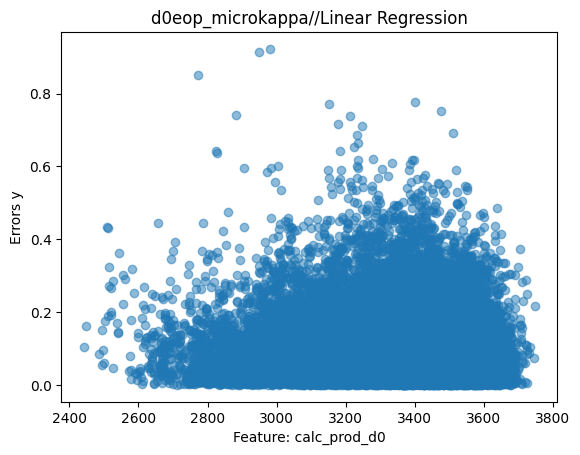

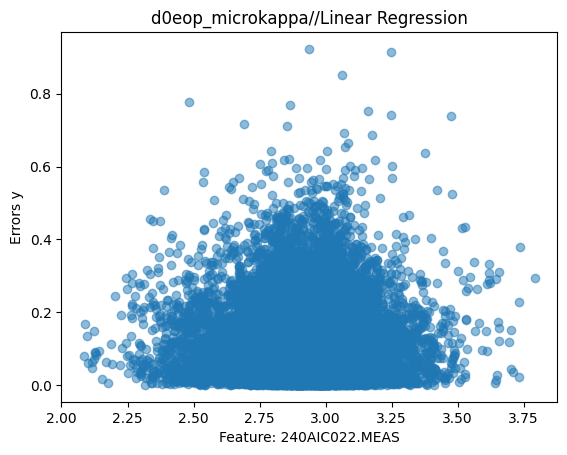

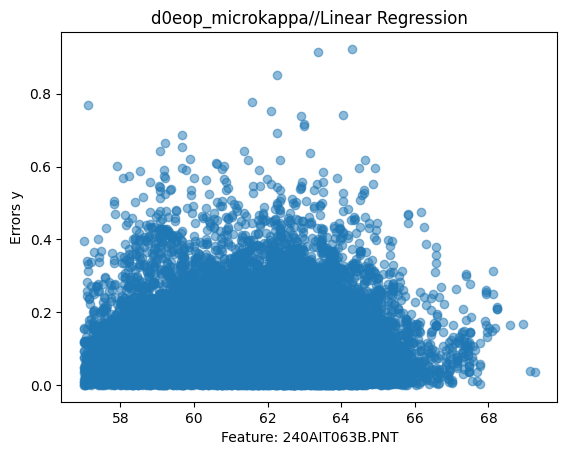

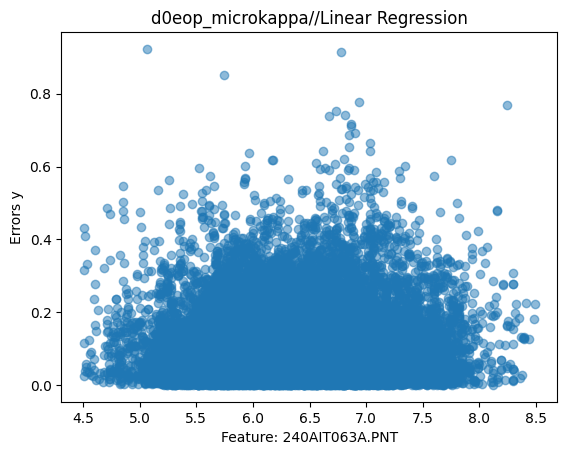

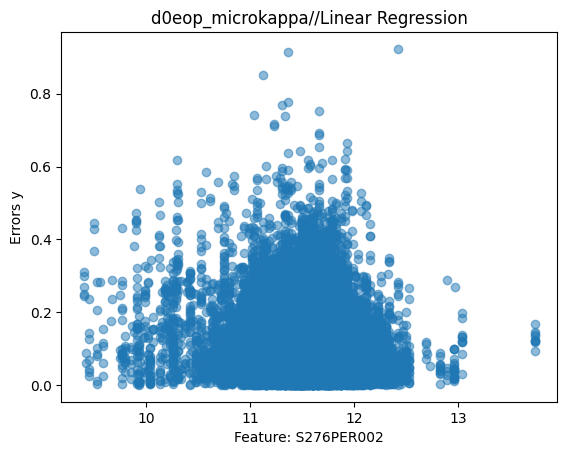

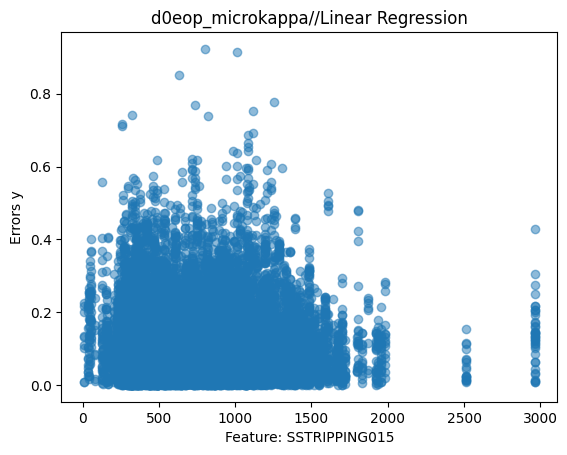

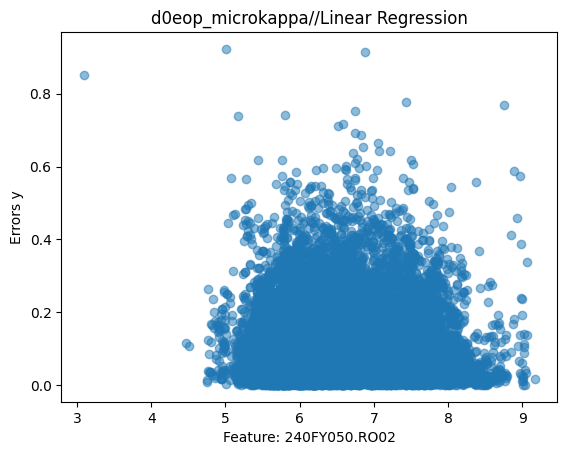

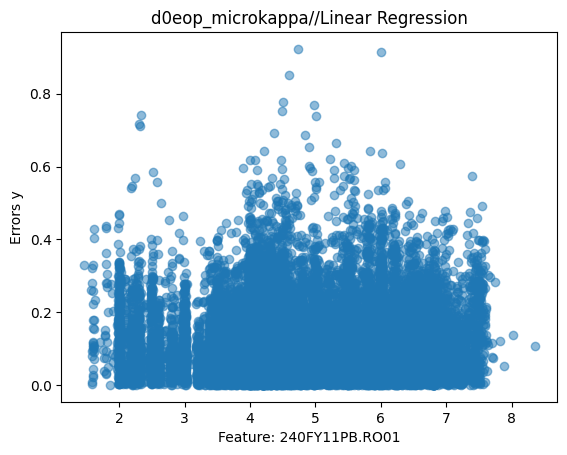

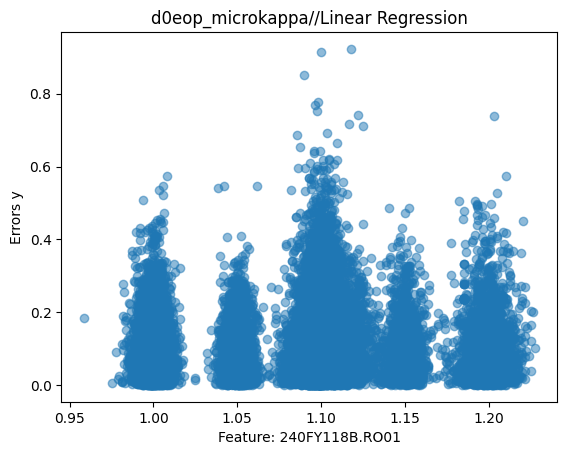

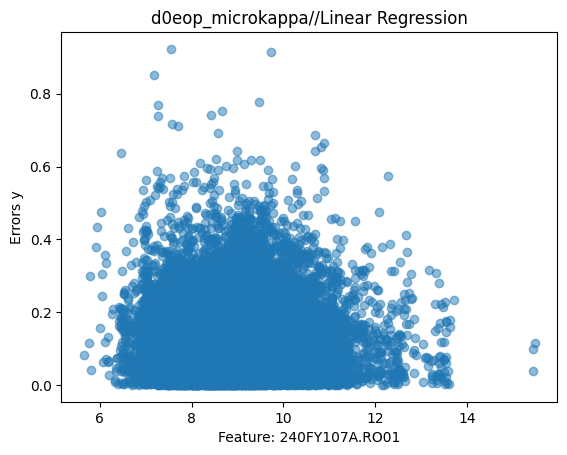

In [24]:
erorrs_vs_features = plot_errors_vs_one_feature(X = X_test,
                                                y = y_test, 
                                                y_pred = y_test_pred, 
                                                title_plot = name_model_and_type,
                                                list_features = X_test.columns.tolist(), 
                                                abs_error = True
                                               )

### 3. Explanaible AI
Hay muchas herramientas de explanaible AI. Aquí se muestran las más clásicas (y utilizando las implementaciones de sklearn cuando es posible). Herramientas:
- Permutation Importances
- Permutation Importances with Noise Features
- Partial Depende Plots (PDP)
- Shapley values

#### 3.1 Permutation Importances
- Obtener la importancia de las variables luego de realizar permutaciones en cada feature de forma individual y observar cómo varía el poder predictivo del modelo
- The estimator is required to be a fitted estimator. X can be the data set used to train the estimator or a hold-out set.

In [25]:
# calculate permutation importances
results = permutation_importance(estimator = model, 
                                 X = X_test, 
                                 y = y_test, 
                                 n_repeats = 30,
                                 random_state = 42
                                )

In [26]:
# define a series with importances (mean) of each feature
list_feartures_tag_description =maestro_tags[maestro_tags['CLASIFICACION'] != 'R']['TAG_DESCRIPTION'].tolist()
df_importances = pd.Series(results.importances_mean, index = list_feartures_tag_description )

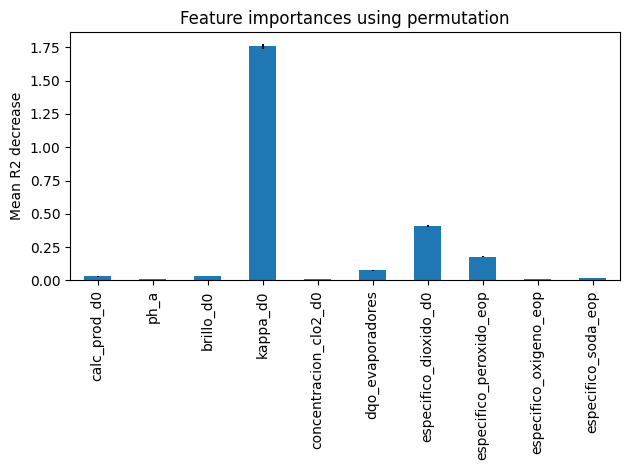

In [27]:
# plot
fig, ax = plt.subplots()
df_importances.plot.bar(yerr = results.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean R2 decrease")
fig.tight_layout()
plt.show()

In [28]:
maestro_tags

,TAG,TAG_DESCRIPTION,DESCRIPCION,ETAPA,CLASIFICACION,USE_PREVIOUS_MODEL,USE_NEXT_MODEL
0,calc_prod_d0,calc_prod_d0,Producción entrada D0 (prod entrada A dezplazada),D0,NC,NaN,NaN
1,240AIC022.MEAS,ph_a,pH entrada etapa Acida,A,NC,NaN,NaN
2,240AIT063B.PNT,brillo_d0,Brillo salida etapa A (entrada D0),D0,NC,NaN,NaN
3,240AIT063A.PNT,kappa_d0,Kappa salida etapa A (entrada D0),D0,NC,NaN,NaN
4,S276PER002,concentracion_clo2_d0,Concentración ClO2,D0,NC,NaN,NaN
5,SSTRIPPING015,dqo_evaporadores,DQO Evaporadores,D0,NC,NaN,NaN
6,240FY050.RO02,especifico_dioxido_d0,Específico ClO2,D0,C,NaN,NaN
7,240FY11PB.RO01,especifico_peroxido_eop,Esp. Peróxido,EOP,C,NaN,NaN
8,240FY118B.RO01,especifico_oxigeno_eop,Esp. Oxígeno,EOP,C,NaN,NaN
9,240FY107A.RO01,especifico_soda_eop,Esp. Soda EOP,EOP,C,NaN,NaN


#### 3.2 Permutation Importances with Noise Features
- Entrenar modelos de ML con 1-2 features que son solo ruido - Distribución Normal con Media 0 y Varianza 1
- Poder evaluar si el modelo utilizado es tan potente que es capaz de ajustarse al ruido y determinar estas variables como más importantes

In [29]:
# create instance model and data noise since original instance model trained
import copy
model_noise = copy.deepcopy(model)

X_train_noise = X_train.copy()
y_train_noise = y_train.copy()
X_test_noise = X_test.copy()
y_test_noise = y_test.copy()

In [30]:
# create dataframe train - test with noise
np.random.seed(42)
X_train_noise['noise_1'] = np.random.normal(size = X_train.shape[0])
X_train_noise['noise_2'] = 10 * np.random.normal(size = X_train.shape[0])

X_test_noise['noise_1'] = np.random.normal(size = X_test.shape[0])
X_test_noise['noise_2'] = 10 * np.random.normal(size = X_test.shape[0])

In [31]:
# train model
model_noise.fit(X_train_noise, y_train_noise)

Pipeline(steps=[('poly_feature_2', PolynomialFeatures()),
                ('lr', LinearRegression())])

In [32]:
# get predictions
y_test_noise_pred = model_noise.predict(X_test_noise)

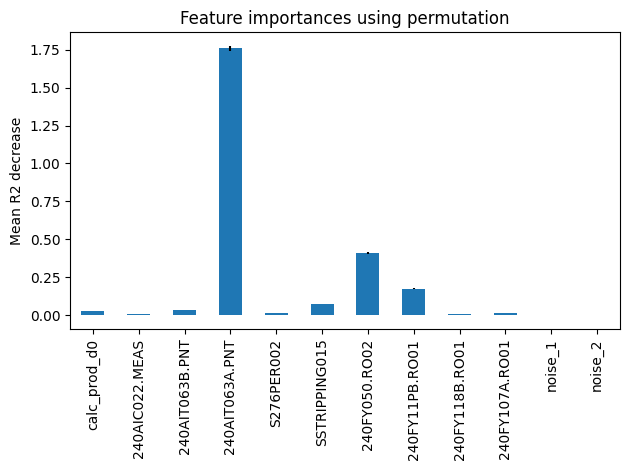

In [33]:
#### PDP - utilizar funcion anterior - re utilizar funcion

# calculate permutation importances
results = permutation_importance(estimator = model_noise, 
                                 X = X_test_noise, 
                                 y = y_test_noise, 
                                 n_repeats = 30,
                                 random_state = 42
                                )

# define a series with importances (mean) of each feature
#list_feartures_tag_description = maestro_tags[maestro_tags['CLASIFICACION'] != 'R']['TAG_DESCRIPTION'].tolist()
df_importances = pd.Series(results.importances_mean, index = X_test_noise.columns.tolist() )

# plot
fig, ax = plt.subplots()
df_importances.plot.bar(yerr = results.importances_std, ax=ax)
ax.set_title("Feature importances using permutation")
ax.set_ylabel("Mean R2 decrease")
fig.tight_layout()
plt.show()

#### 3.3 Partial Dependence Plot
Gráficos de dependencia parcial. Mostrar cómo cambian los valores de la predicción dado el cambio de los valores de una feature mientras se mantiene el resto en sus valores medios

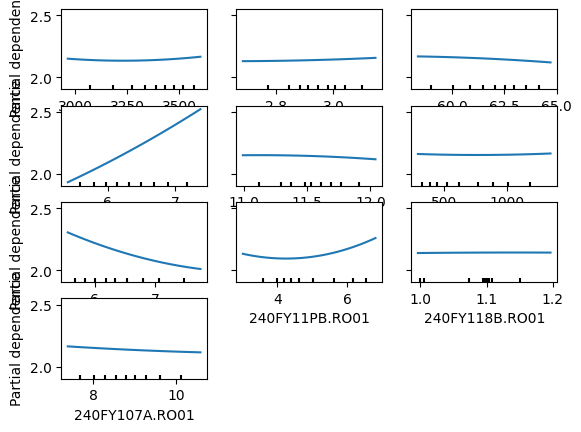

In [34]:
# PDP - all features

# plot
display = PartialDependenceDisplay.from_estimator(
    estimator = model,
    X = X_test,
    random_state = 42,
    features = X_test.columns.tolist(),
    n_cols = 3
)

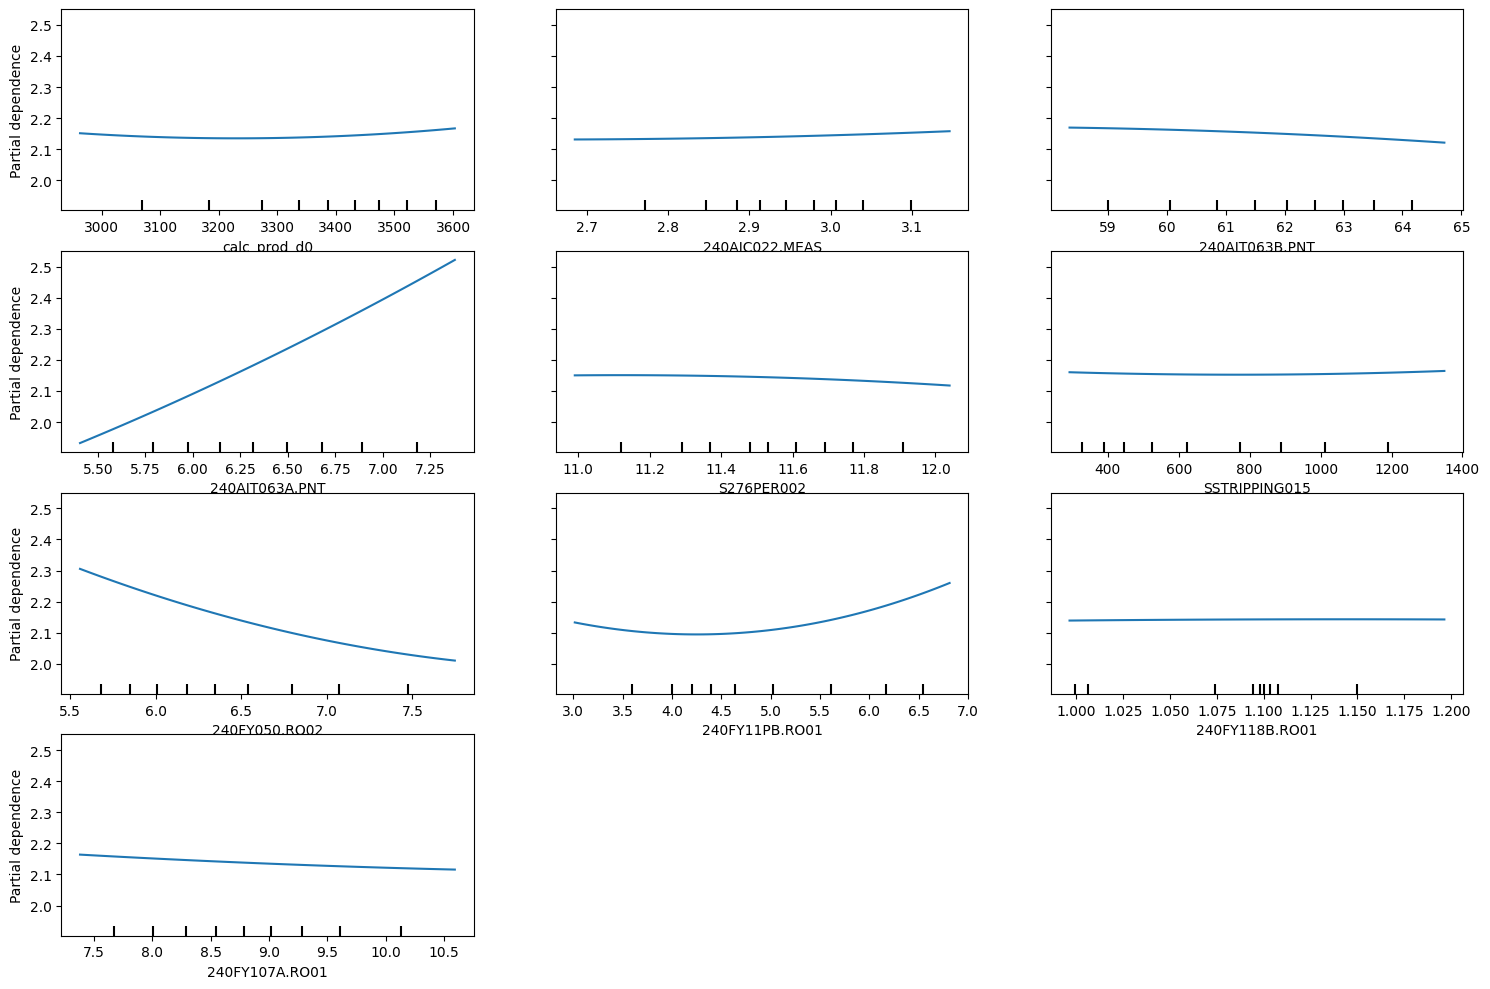

In [35]:
# Crear una figura con el tamaño deseado
plt.figure(figsize=(15, 10))

# Mostrar el gráfico
display.plot(ax=plt.gca())  # Utiliza el eje actual de la figura actual
plt.tight_layout()

# Mostrar la figura
plt.show()

#### 3.4 Shampley Values
Plots utilizando el package SHAP

In [36]:
# TO DO - tengo códidgos - me falta el ambiente estable con gurobi

### 4. Perturbation test - Sensitivy Analysis

In [37]:
# TO DO - no tengo códigos

### 5. Metrics by segments

#### 5.0 Analysis

#### 5.1 Segment by most important feature

In [38]:
tag_segment = '240AIT063A.PNT'

In [39]:
# get percentile and bins
percentile_index, bins = pd.qcut(X_test[tag_segment], 5, labels=False, retbins=True)

In [40]:
# add columns percentile in y test
y_test_percentile = y_test.copy()
y_test_percentile['percentile_index'] = percentile_index

# add columns percentile in y test pred
y_test_pred_percentile = y_test_pred.copy()
y_test_pred_percentile['percentile_index'] = percentile_index

In [41]:
# show metrics
metrics_percentile = pd.DataFrame()
for index in range(5):
    
    # calculate values start and end
    start_segment = round(bins[index], 3)
    end_segment = round(bins[index+1], 3)
    print(f' --------- --------- {index} --------- ---------')
    print(f'VALOR INICIO FEATURE: {start_segment} // VALOR FIN FEATURE: {end_segment}')


    # filter test data ground truth
    y_test_percentile_aux = y_test_percentile[y_test_percentile['percentile_index'] == index]
    y_test_percentile_aux = y_test_percentile_aux.drop(columns = 'percentile_index')

    
    # filter test data pred
    y_test_pred_percentile_aux = y_test_pred_percentile[y_test_pred_percentile['percentile_index'] == index]
    y_test_pred_percentile_aux = y_test_pred_percentile_aux.drop(columns = 'percentile_index')

    
    # calculate metrics
    metrics_percentile_aux = calculate_metrics_regressors_models(y = y_test_percentile_aux,
                                        y_pred = y_test_pred_percentile_aux, 
                                        model_name = f'Percentile {index}', 
                                        decimals_round = None
                                       )

    # append
    metrics_percentile = pd.concat([metrics_percentile, metrics_percentile_aux])

 --------- --------- 0 --------- ---------
VALOR INICIO FEATURE: 4.506 // VALOR FIN FEATURE: 5.789
 --------- --------- 1 --------- ---------
VALOR INICIO FEATURE: 5.789 // VALOR FIN FEATURE: 6.145
 --------- --------- 2 --------- ---------
VALOR INICIO FEATURE: 6.145 // VALOR FIN FEATURE: 6.494
 --------- --------- 3 --------- ---------
VALOR INICIO FEATURE: 6.494 // VALOR FIN FEATURE: 6.89
 --------- --------- 4 --------- ---------
VALOR INICIO FEATURE: 6.89 // VALOR FIN FEATURE: 8.488


In [42]:
metrics_percentile

,r2,mse,rmse,rmse_mean_ratio(%),rmse_iqr_ratio(%),mae,mae_mean_ratio(%),mae_iqr_ratio(%)
Percentile 0,0.438537,0.015406,0.124121,6.60,63.24,0.091091,4.84,46.41
Percentile 1,0.325932,0.018604,0.136395,6.66,58.88,0.106104,5.18,45.81
Percentile 2,0.199720,0.019008,0.137869,6.34,66.24,0.109428,5.03,52.58
Percentile 3,0.231748,0.020514,0.143226,6.33,83.25,0.106149,4.69,61.70
Percentile 4,0.300432,0.018508,0.136043,5.84,88.10,0.097940,4.20,63.42


In [43]:
# append original score
pd.concat([metrics, metrics_percentile])

,r2,mse,rmse,rmse_mean_ratio(%),rmse_iqr_ratio(%),mae,mae_mean_ratio(%),mae_iqr_ratio(%)
d0eop_microkappa//Linear Regression,0.646607,0.018405,0.135663,6.34,42.10,0.102126,4.77,31.69
Percentile 0,0.438537,0.015406,0.124121,6.60,63.24,0.091091,4.84,46.41
Percentile 1,0.325932,0.018604,0.136395,6.66,58.88,0.106104,5.18,45.81
Percentile 2,0.199720,0.019008,0.137869,6.34,66.24,0.109428,5.03,52.58
Percentile 3,0.231748,0.020514,0.143226,6.33,83.25,0.106149,4.69,61.70
Percentile 4,0.300432,0.018508,0.136043,5.84,88.10,0.097940,4.20,63.42
